# Reverse-time (and Kirchhoff) migration
Notebook by Rodrigue Lelotte & Jules Sanchez

## Instructions for use
Each part of this notebook represents one part of the problem set (*i.e.* full-aperture, partial-aperture, and partial-aperture with broadband signal). For the last part (*i.e.* adding noise), it suffices to either (de)comment the lines << W_reel = ... >> and << W_cplx = ... >> to each previous part. 

**/!\** Beware that some part take quite some time to finish; you might play with the parameters to speed up the overall process (*e.g.* lower the number of transducers N !) **/!\**

**/!\** Note that this notebook is fully functional on our side. Please contact us if something isn't working properly **/!\**


### Some useful functions 

In [307]:
import numpy as np 
from scipy.special import j0, y0, i0
import matplotlib.pyplot as plt
plt.style.use("default")

# Helpers for Green functions
def J0_2(omega,x,xref):
    return j0(omega*np.linalg.norm(x-xref,2,axis=-1))**2
    
def h0(s):
    return complex(j0(s),y0(s))

def Go_F(omega,x,y):
    return (1/4)*h0(omega*(np.linalg.norm(x-y,2,axis=-1)))*complex(0,1)

def G_F(omega,x,y,x_ref,rho):
    #Born Approximation of G_F for ponctual rho
    return omega**2*Go_F(omega,x,x_ref)*rho*Go_F(omega,x_ref,y) #+ Go_F(omega,x,y)

def I0_2(omega,x,xref):
    #KM approxmication. See report.
    return i0(complex(0,omega*np.linalg.norm(x-xref,2,axis=-1)))**2

### Defining the datasets 

In [308]:
# Parameters (PLAY WITH THOSE !)
N = 100 
N1 = 100
N2 = 40
R0 = 100
R1 = 100
R2 = 20

def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

transducers_circle = circle_points([R0],[N])[0] # Full aperture
transducers_linear_1 = np.vstack((np.linspace(-R1/2,R1/2,N1),np.zeros(N1))).T # Partial aperture
transducers_linear_2 = np.vstack((np.linspace(-R2/2,R2/2,N2),np.zeros(N2))).T # Partial aperture (w/ bandwidth)

# Reflectors loci

x_ = 5
y_ = 5
reso = 10
x_ref = np.array([10,20]) # Full aperture
grid = np.zeros((2*reso+1,2*reso+1,2))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        grid[k,l] = np.array([x_ref[0] + (k-reso)/reso*x_ , x_ref[1] + (l-reso)/reso*y_])

x_ref_2 = np.array([0,100]) # Partial aperture 
grid_2 = np.zeros((2*reso+1,2*reso+1,2))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        grid_2[k,l] = np.array([x_ref_2[0] + (k-reso)/reso*x_ , x_ref_2[1] + (l-reso)/reso*y_])
rho = 0.5

# Noise variance (part V)
sigma = 1 # CHANGE THIS

# Frequency bandwith (part IV)
omega_o = 2*np.pi
bandwith = 0.99*omega_o
omega_resolution = 20
omegas = np.linspace(omega_o-bandwith,omega_o+bandwith,omega_resolution)

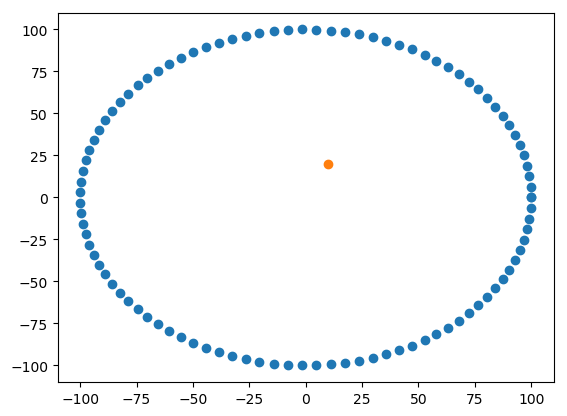

In [309]:
# Visualize the first setup
plt.scatter(transducers_circle[:,0],transducers_circle[:,1])
plt.scatter(x_ref[0],x_ref[1])
plt.show()

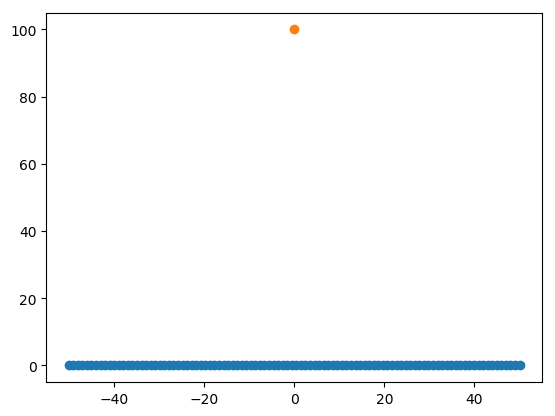

In [310]:
# Visualize the second setup
plt.scatter(transducers_linear_1[:,0],transducers_linear_1[:,1])
plt.scatter(x_ref_2[0],x_ref_2[1])

### Part II : Full-aperture 

In [311]:
# Part II

U = np.ones(shape = (N,N), dtype = complex)
for r in range(N): 
    for s in range(N):
        if s != r:
            U[r,s] = G_F(omega_o,transducers_circle[r], transducers_circle[s], x_ref, rho)
        if s == r :
            U[r,s] = 0

## Add noise
W_reel = np.random.normal(0, sigma**2/2, size = U.shape)
W_cplx = np.random.normal(0, sigma**2/2, size = U.shape)
U = U + W_reel + 1j*W_cplx
np.fill_diagonal(U, 0)

rho_RT = np.zeros((2*reso + 1, 2*reso+1), dtype = complex)
rho_KM = np.zeros((2*reso + 1, 2*reso+1), dtype = complex)
for k in range(2*reso + 1):
    for l in range(2*reso + 1):
        x_local = grid[k,l]
        for r in range(N): 
            for s in range(N):
                rho_RT[k,l] += Go_F(omega_o,x_local,transducers_circle[s])*Go_F(omega_o,transducers_circle[r],x_local)*np.conj(U[r,s])
                rho_KM[k,l] += np.exp(complex(0,omega_o*(np.linalg.norm(x_local-transducers_circle[s])+np.linalg.norm(x_local-transducers_circle[r]))))*np.conj(U[r,s])
        rho_RT[k,l] *= (0.5/np.pi)
        rho_KM[k,l] /= N**2
rho_RT = np.abs(rho_RT)
rho_KM = np.abs(rho_KM)


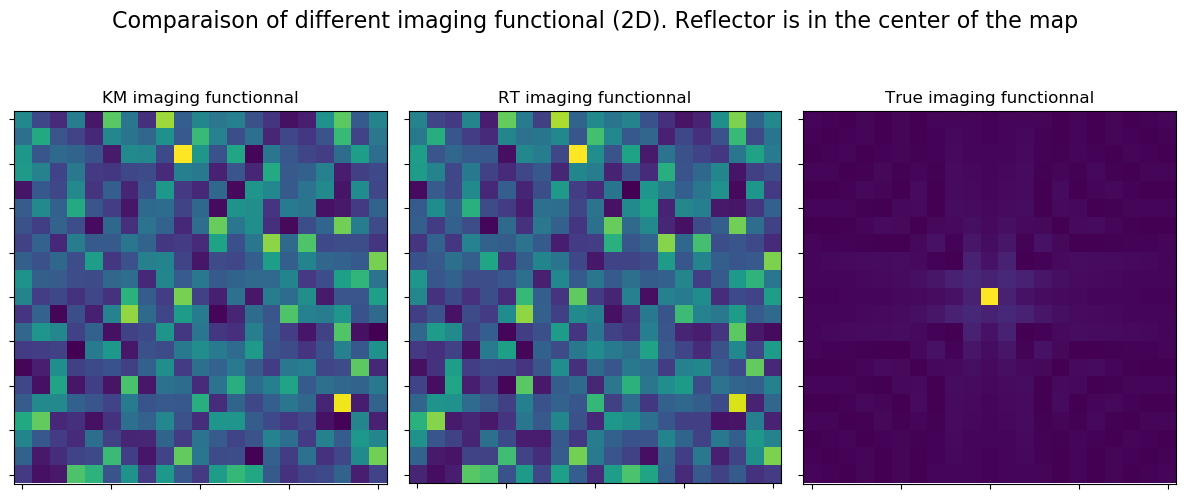

In [312]:
# Results for II

J = np.zeros((2*reso+1,2*reso+1))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        J[k,l] = J0_2(omega_o,x_local,x_ref)
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

ax1 = axs[0]
ax1.imshow(rho_KM.T)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax = axs[1]
ax.imshow(rho_RT.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = axs[2]
ax.imshow(J.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

axs[0].set_title('KM imaging functionnal')
axs[1].set_title('RT imaging functionnal')
axs[2].set_title('True imaging functionnal')
fig.suptitle('Comparaison of different imaging functional (2D). Reflector is in the center of the map', fontsize=16)

plt.tight_layout()
plt.show()

### Part III : Partial-aperture (w/ time-harmonic signal)

In [313]:
# Part III

U1 = np.ones(shape = (N1,N1), dtype = complex)
for r in range(N1): 
    for s in range(N1):
        if s != r:
            U1[r,s] = G_F(omega_o, transducers_linear_1[r], transducers_linear_1[s], x_ref_2, rho)
        if s == r :
            U1[r,s] = 0

##Add noise
W1_reel = np.random.normal(0, sigma**2/2, size = U1.shape)
W1_cplx = np.random.normal(0, sigma**2/2, size = U1.shape)
U1 = U1 + W1_reel + 1j*W1_cplx
np.fill_diagonal(U1, 0)

rho_RT1 = np.zeros((2*reso + 1, 2*reso + 1), dtype = complex)
rho_KM1 = np.zeros((2*reso + 1, 2*reso + 1), dtype = complex)
rho_MUSIC = np.zeros((2*reso + 1, 2*reso + 1))
u, s, vh = np.linalg.svd(U1)
v1 = vh[0]
for k in range(2*reso + 1):
    for l in range(2*reso + 1):
        x_local = grid_2[k,l]
        g = np.zeros(N1, dtype = complex)
        for r in range(N1): 
            g[r] = Go_F(omega_o,x_local,transducers_linear_1[r])
            for s in range(N1):
                rho_RT1[k,l] += Go_F(omega_o,x_local,transducers_linear_1[s])*Go_F(omega_o,x_local,transducers_linear_1[r])*np.conj(U1[r,s])
                rho_KM1[k,l] += np.exp(complex(0,omega_o*(np.linalg.norm(x_local-transducers_linear_1[s])+np.linalg.norm(x_local-transducers_linear_1[r]))))*np.conj(U1[r,s])
        rho_RT1[k,l] *= (0.5/np.pi)
        rho_KM1[k,l] /= N1**2
        rho_MUSIC[k,l] = np.abs(np.sum(g*np.conj(v1)))**2
rho_RT1 = np.abs(rho_RT1)
rho_KM1 = np.abs(rho_KM1)


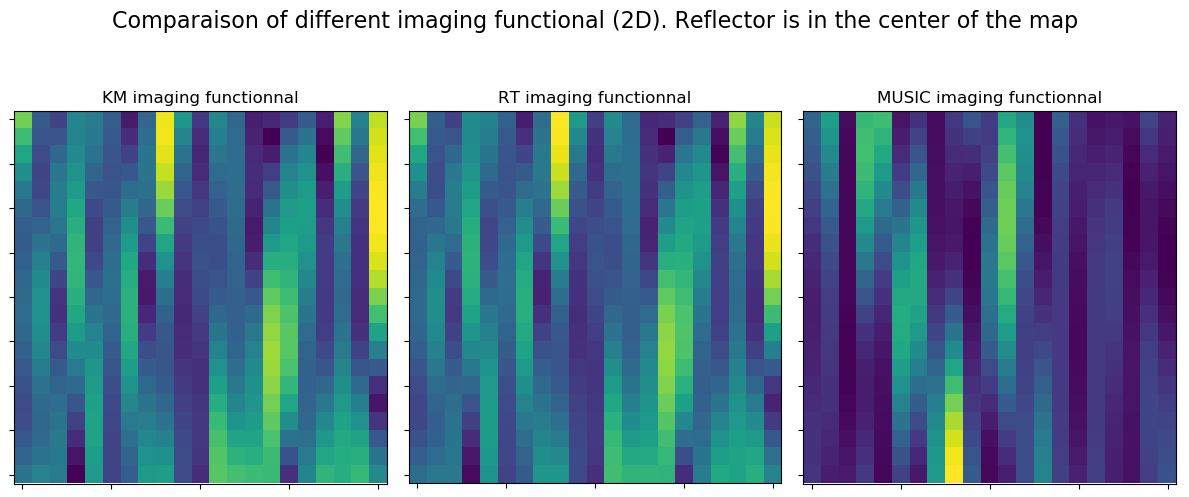

/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


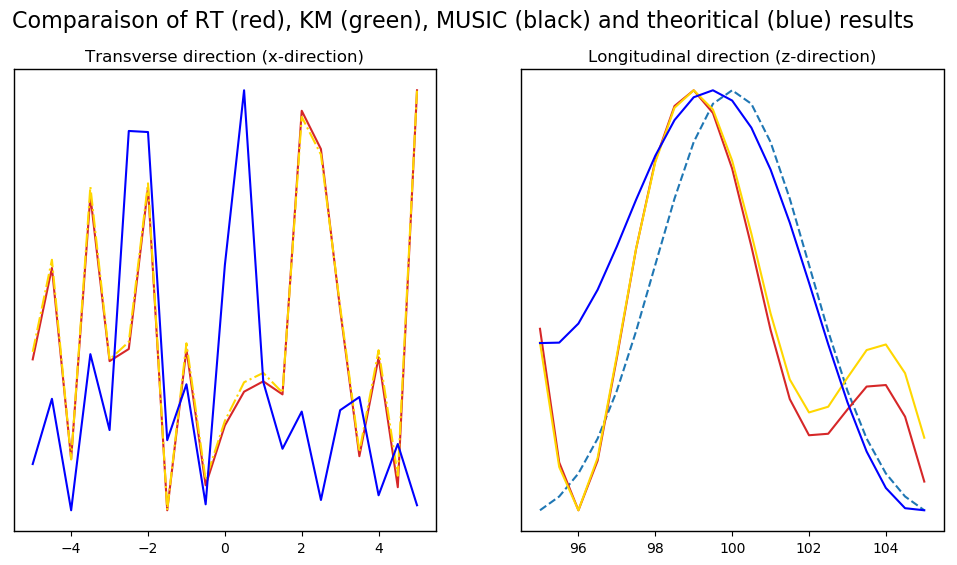

In [314]:
# Results for III

import scipy.integrate as integrate
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

ax1 = axs[0]
ax1.imshow(rho_KM1.T)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax = axs[1]
ax.imshow(rho_RT1.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = axs[2]
ax.imshow(np.abs(rho_MUSIC.T))
ax.set_xticklabels([])
ax.set_yticklabels([])

axs[0].set_title('KM imaging functionnal')
axs[1].set_title('RT imaging functionnal')
axs[2].set_title('MUSIC imaging functionnal')
fig.suptitle('Comparaison of different imaging functional (2D). Reflector is in the center of the map', fontsize=16)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
S = np.zeros(2*reso+1, dtype = complex)
colorRT = 'tab:red'
colorKM = 'gold'
colorMUSIC = 'blue'

z_fixed = reso
rc = 2*np.pi/omega_o * np.linalg.norm(x_ref_2) / R1
for k in range(2*reso+1):
    x_local = grid_2[k,z_fixed][0]
    S[k] = np.sinc(np.pi*(np.linalg.norm(x_local - x_ref_2[0]))/rc)**2

ax1 = axs[0]
ax1.plot(grid_2[:,z_fixed,0],np.abs(S), label = 'theoritical results', ls = "--")
ax2 = ax1.twinx()  
ax2.plot(grid_2[:,z_fixed,0],rho_RT1[:,z_fixed], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[:,z_fixed,0],rho_KM1[:,z_fixed], label = 'KM results', color=colorKM, ls= "-.")
ax4 = ax1.twinx()
ax4.plot(grid_2[:,z_fixed,0],rho_MUSIC[:,z_fixed], label = 'MUSIC results', color=colorMUSIC)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

S = np.zeros(2*reso+1, dtype = complex)
x_fixed = reso
rl = 2*2*np.pi/omega_o * np.linalg.norm(x_ref_2)**2 / R1**2
for k in range(2*reso+1):
    z_local = grid_2[x_fixed,k][1]
    S[k] = np.abs(integrate.quad(lambda x: np.exp(complex(0,-0.5*np.pi*x**2*np.linalg.norm(z_local - x_ref_2[1])/rl)), 0, 1)[0])**2

ax1 = axs[1]
ax1.plot(grid_2[x_fixed,:,1],np.abs(S), label = 'theoritical results', ls = '--')
ax2 = ax1.twinx()  
ax2.plot(grid_2[x_fixed,:,1],rho_RT1[x_fixed,:], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[x_fixed,:,1],rho_KM1[x_fixed,:], label = 'KM results', color=colorKM)
ax4 = ax1.twinx()
ax4.plot(grid_2[x_fixed,:,1],rho_MUSIC[x_fixed,:], label = 'MUSIC results', color=colorMUSIC)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
axs[0].set_title('Transverse direction (x-direction)')
axs[1].set_title('Longitudinal direction (z-direction)')
fig.suptitle('Comparaison of RT (red), KM (green), MUSIC (black) and theoritical (blue) results', fontsize=16)
plt.show()


### Part IV : Partial-aperture (w/ broadband signal)

In [316]:
# Part IV

U2 = np.ones(shape=(omega_resolution,N2,N2), dtype = complex)
for i in range(omega_resolution):
    omega = omegas[i]
    for r in range(N2): 
        for s in range(N2):
            if s != r:
                U2[i,r,s] = G_F(omega,transducers_linear_2[r],transducers_linear_2[s],x_ref_2,rho)
            if s == r :
                U2[i,r,s] = 0

##Add noise
W2_reel = np.random.normal(0,sigma**2/2,size=U2.shape)
W2_cplx = np.random.normal(0,sigma**2/2,size=U2.shape)
U2 = U2 + W2_reel + 1j*W2_cplx



rho_RT2 = np.zeros((2*reso+1,2*reso+1),dtype = complex)
rho_KM2 = np.zeros((2*reso+1,2*reso+1),dtype = complex)
for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid_2[k,l]
        for i in range(omega_resolution):
            omega = omegas[i]
            for r in range(N2): 
                for s in range(N2):
                    rho_RT2[k,l] += Go_F(omega,x_local,transducers_linear_2[s])*omega**2*Go_F(omega,x_local,transducers_linear_2[r])*np.conj(U2[i,r,s])
                    rho_KM2[k,l] += np.exp(complex(0,omega*(np.linalg.norm(x_local-transducers_linear_2[s])+np.linalg.norm(x_local-transducers_linear_2[r]))))*np.conj(U2[i,r,s])
        rho_KM2[k,l] /= N2**2
        rho_RT2[k,l] *= (0.5/np.pi)
rho_KM2 = np.abs(rho_KM2)
rho_RT2 = np.abs(rho_RT2)

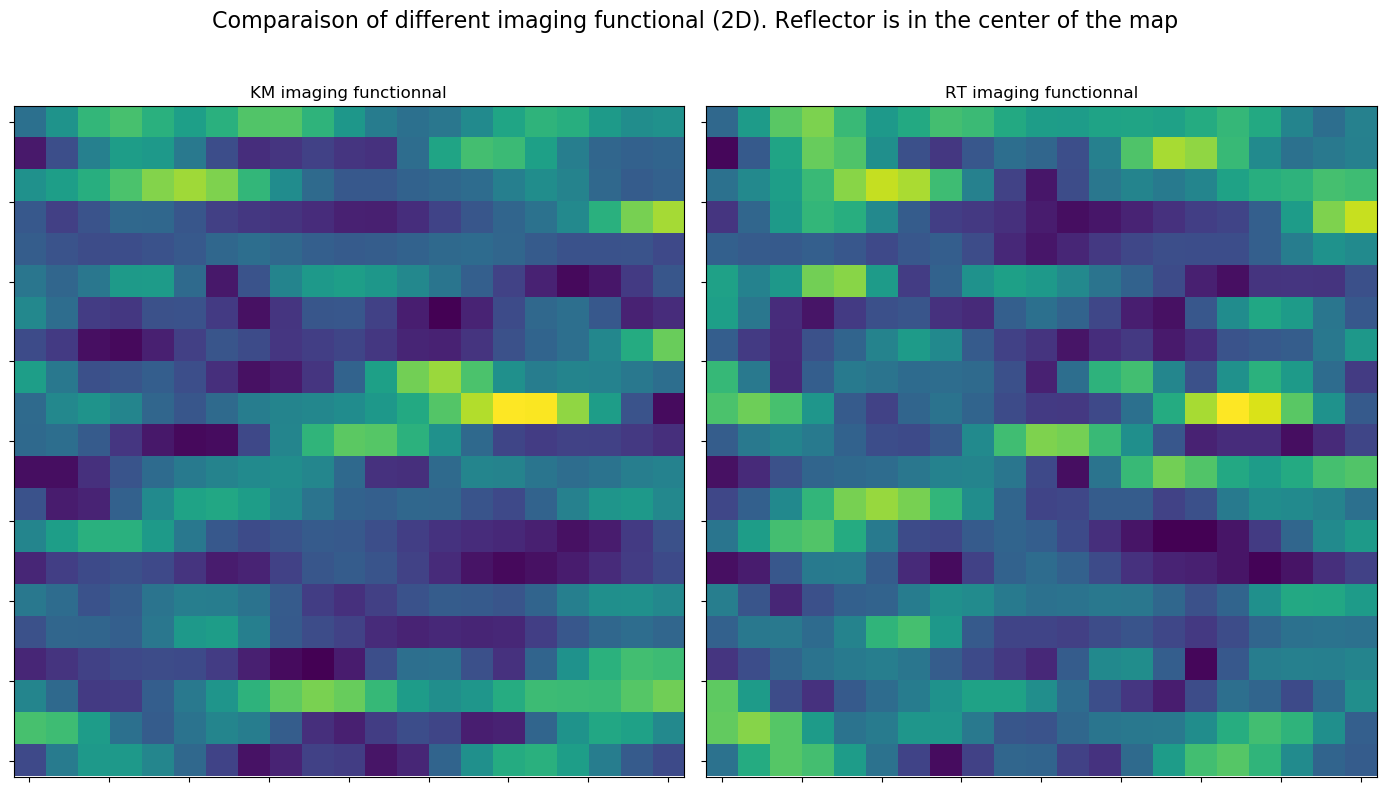

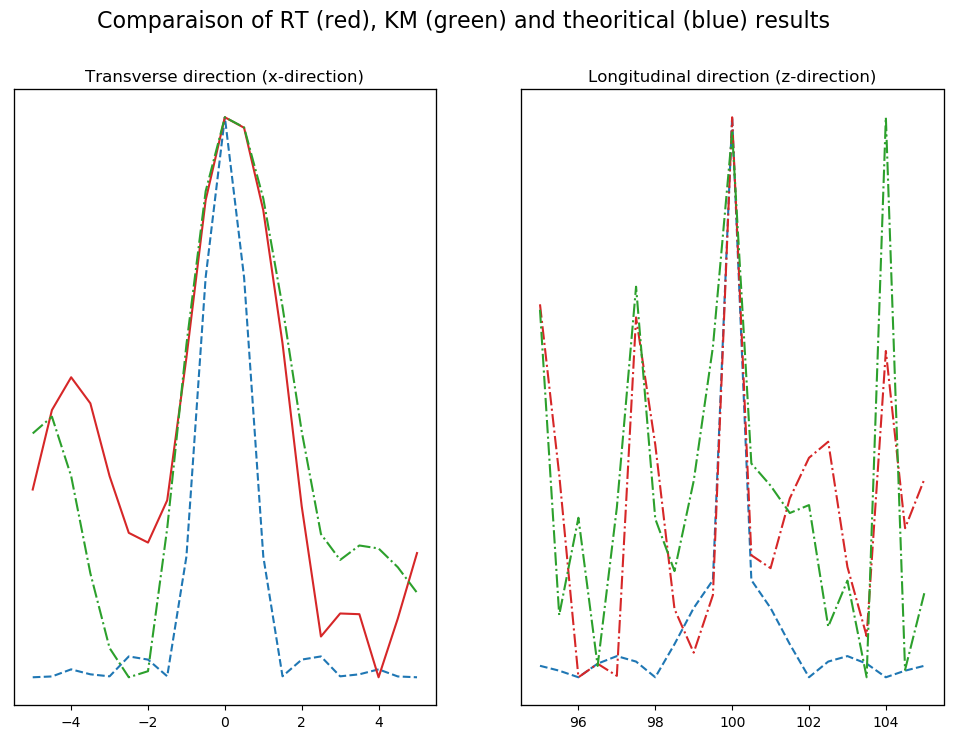

In [317]:
# Results for IV

import scipy.integrate as integrate
fig, axs = plt.subplots(1, 2, figsize=(14, 9))

ax1 = axs[0]
ax1.imshow(rho_KM2.T)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax = axs[1]
ax.imshow(rho_RT2.T)
ax.set_xticklabels([])
ax.set_yticklabels([])


axs[0].set_title('KM imaging functionnal')
axs[1].set_title('RT imaging functionnal')
fig.suptitle('Comparaison of different imaging functional (2D). Reflector is in the center of the map', fontsize=16)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 8))
S = np.zeros(2*reso+1)
colorRT = 'tab:red'
colorKM = 'tab:green'

z_fixed = reso
rc = 2*np.pi/omega_o * np.linalg.norm(x_ref_2) / R2
for k in range(2*reso+1):
    x_local = grid_2[k,z_fixed][0]
    S[k] = np.sinc(np.pi*(np.linalg.norm(x_local - x_ref_2[0]))/rc)**2

ax1 = axs[0]
ax1.plot(grid_2[:,z_fixed,0],S, label = 'theoritical results', ls = '--')
ax2 = ax1.twinx()  
ax2.plot(grid_2[:,z_fixed,0],rho_RT2[:,z_fixed], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[:,z_fixed,0],rho_KM2[:,z_fixed], label = 'KM results', color=colorKM, ls = '-.')
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

S = np.zeros(2*reso+1)
x_fixed = reso
for k in range(2*reso+1):
    z_local = grid_2[x_fixed,k][1]
    S[k] = np.abs(np.sinc(2*bandwith*(np.linalg.norm(z_local - x_ref_2[1]))/rc))

ax1 = axs[1]
ax1.plot(grid_2[x_fixed,:,1], S, label = 'theoritical results', ls = '--')
ax2 = ax1.twinx()  
ax2.plot(grid_2[x_fixed,:,1], rho_RT2[x_fixed,:], label = 'RT results', color=colorRT, ls = "-.")
ax3 = ax1.twinx()
ax3.plot(grid_2[x_fixed,:,1], rho_KM2[x_fixed,:], label = 'KM results', color=colorKM, ls = '-.')
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
axs[0].set_title('Transverse direction (x-direction)')
axs[1].set_title('Longitudinal direction (z-direction)')
fig.suptitle('Comparaison of RT (red), KM (green) and theoritical (blue) results', fontsize=16)
plt.show()

### Part V: Impact of parameters on the localization errors 

In [293]:
#Impact of N in localization error

from fast_script import exo_2

deltas = [0.01, 0.5, 1]
Ns = np.arange(1,20)
loc_errors_KM = {}
loc_errors_RT= {}
di = 0
for d in deltas:
    loc_errors_RT[d] = {}
    loc_errors_KM[d] = {}
    for n in Ns:
        loc_errors_RT[d][n] = []
        loc_errors_KM[d][n] = []
        transducers = circle_points([R0],[n])[0]
        for j in range(30):
            RT, KM = exo_2(d, n, grid, np.array([omega_o]), transducers, x_ref, rho, reso)
            loc_errors_RT[d][n].append(np.linalg.norm(grid[np.unravel_index(RT.argmax(), RT.shape)] - x_ref))
            loc_errors_KM[d][n].append(np.linalg.norm(grid[np.unravel_index(RT.argmax(), RT.shape)] - x_ref))
    di += 1
    
    

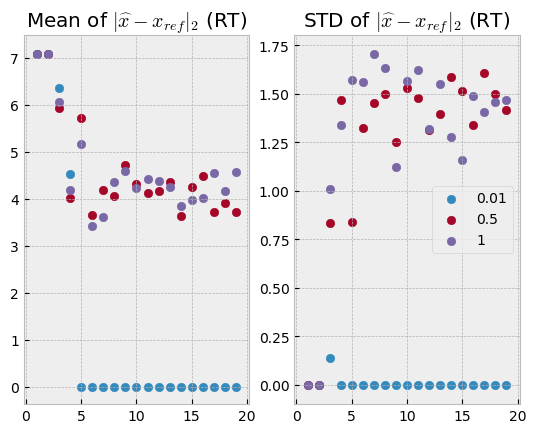

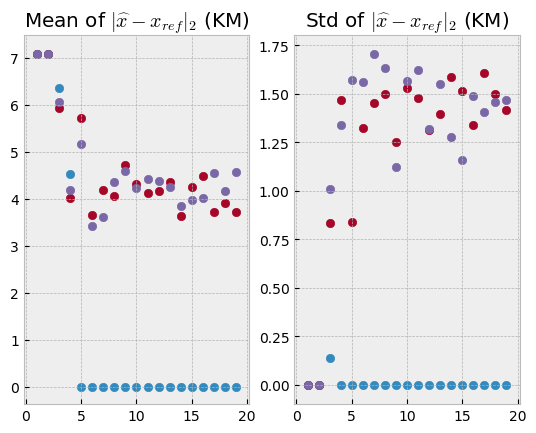

In [294]:
fig, axs = plt.subplots(1, 2)

for d in deltas:
    means = []
    stds = []
    for n in Ns:
        means.append(np.mean(loc_errors_RT[d][n]))
        stds.append(np.std(loc_errors_RT[d][n]))
    axs[0].scatter(Ns, means, label = d)
    axs[1].scatter(Ns, stds, label = d)
    axs[0].set_title('Mean of $|\widehat{x} - x_{ref}|_2$ (RT)')
    axs[1].set_title('STD of $|\widehat{x} - x_{ref}|_2$ (RT)')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 2)

for d in deltas:
    means = []
    stds = []
    for n in Ns:
        means.append(np.mean(loc_errors_KM[d][n]))
        stds.append(np.std(loc_errors_KM[d][n]))
    axs[0].scatter(Ns, means, label = d)
    axs[1].scatter(Ns, stds, label = d)
    axs[0].set_title('Mean of $|\widehat{x} - x_{ref}|_2$ (KM)')
    axs[1].set_title('Std of $|\widehat{x} - x_{ref}|_2$ (KM)')
plt.show()

In [280]:
# Impact of R in localization error

deltas = [0.01, 0.5, 1]
Rs = np.arange(20,150,10)
loc_errors_KM = {}
loc_errors_RT= {}
for d in deltas:
    loc_errors_RT[d] = {}
    loc_errors_KM[d] = {}
    for r in Rs:
        loc_errors_RT[d][r] = []
        loc_errors_KM[d][r] = []
        transducers = circle_points([r],[N])[0]
        for j in range(30):
            RT, KM = exo_2(d,N,grid,np.array([omega_o]),transducers,x_ref,rho,reso)
            loc_errors_RT[d][r].append(np.linalg.norm(grid[np.unravel_index(RT.argmax(), RT.shape)] - x_ref))
            loc_errors_KM[d][r].append(np.linalg.norm(grid[np.unravel_index(RT.argmax(), RT.shape)] - x_ref))

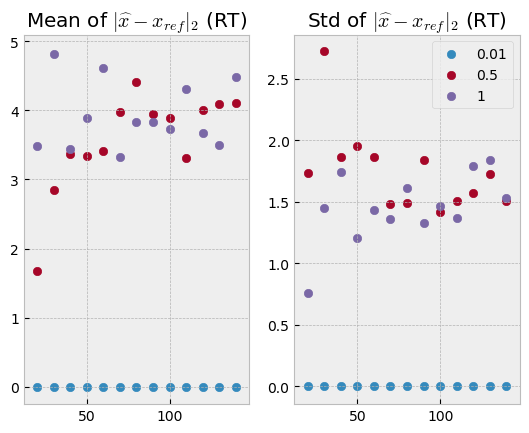

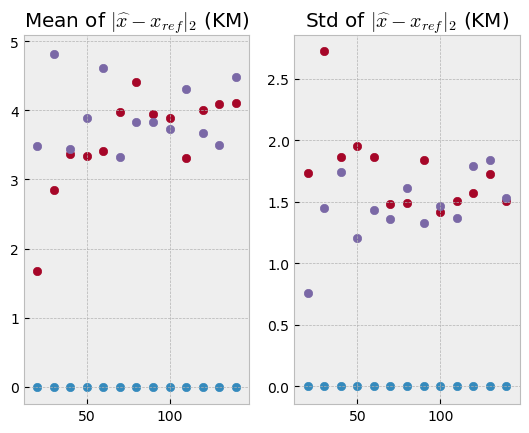

In [291]:
fig, axs = plt.subplots(1, 2)
plt.style.use("bmh")
for d in deltas:
    means = []
    stds = []
    for r in Rs:
        means.append(np.mean(loc_errors_RT[d][r]))
        stds.append(np.std(loc_errors_RT[d][r]))
    axs[0].scatter(Rs,means, label = d)
    axs[1].scatter(Rs,stds, label = d)
    axs[0].set_title('Mean of $|\widehat{x} - x_{ref}|_2$ (RT)')
    axs[1].set_title('Std of $|\widehat{x} - x_{ref}|_2$ (RT)')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 2)

for d in deltas:
    means = []
    stds = []
    for r in Rs:
        means.append(np.mean(loc_errors_KM[d][r]))
        stds.append(np.std(loc_errors_KM[d][r]))
    axs[0].scatter(Rs,means, label = d)
    axs[1].scatter(Rs,stds, label = d)
    axs[0].set_title('Mean of $|\widehat{x} - x_{ref}|_2$ (KM)')
    axs[1].set_title('Std of $|\widehat{x} - x_{ref}|_2$ (KM)')
plt.show()

In [301]:
# Impact of bandwith in localization error

deltas = [0.2, 0.5, 1]
bdws = np.linspace(0.01, 0.1, 10)
loc_errors_KM = {}
loc_errors_RT= {}
for d in deltas:
    loc_errors_RT[d] = {}
    loc_errors_KM[d] = {}
    for b in bdws:
        omegas = np.linspace(omega_o-b,omega_o+b,omega_resolution)
        loc_errors_RT[d][b] = []
        loc_errors_KM[d][b] = []
        transducers = np.vstack((np.linspace(-R2/2,R2/2,N2),np.zeros(N2))).T
        for j in range(30):
            RT, KM = exo_2(d, N2, grid, omegas, transducers, x_ref_2, rho, reso)
            loc_errors_RT[d][b].append(np.linalg.norm(grid[np.unravel_index(RT.argmax(), RT.shape)] - x_ref_2))
            loc_errors_KM[d][b].append(np.linalg.norm(grid[np.unravel_index(RT.argmax(), RT.shape)] - x_ref_2))

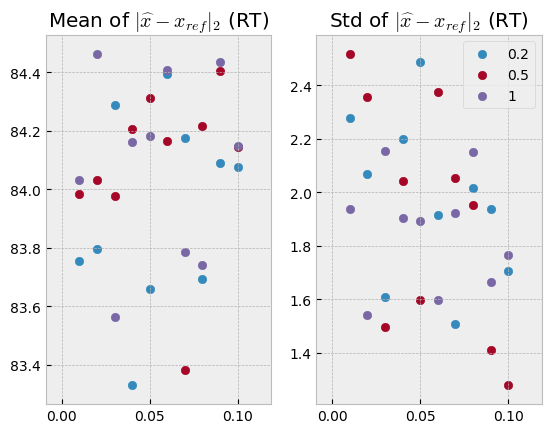

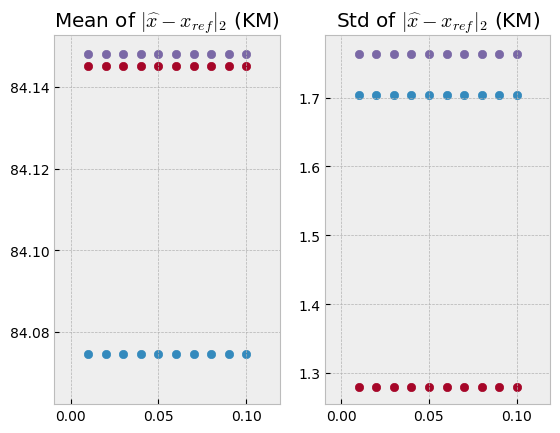

In [302]:
fig, axs = plt.subplots(1, 2)

for d in deltas:
    means = []
    stds = []
    for b in bdws:
        means.append(np.mean(loc_errors_RT[d][b]))
        stds.append(np.std(loc_errors_RT[d][b]))
    axs[0].scatter(bdws,means, label = d)
    axs[1].scatter(bdws,stds, label = d)
    axs[0].set_title('Mean of $|\widehat{x} - x_{ref}|_2$ (RT)')
    axs[1].set_title('Std of $|\widehat{x} - x_{ref}|_2$ (RT)')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 2)

for d in deltas:
    means = []
    stds = []
    for r in bdws:
        means.append(np.mean(loc_errors_KM[d][b]))
        stds.append(np.std(loc_errors_KM[d][b]))
    axs[0].scatter(bdws,means, label = d)
    axs[1].scatter(bdws,stds, label = d)
    axs[0].set_title('Mean of $|\widehat{x} - x_{ref}|_2$ (KM)')
    axs[1].set_title('Std of $|\widehat{x} - x_{ref}|_2$ (KM)')
plt.show()